# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook, data_wrangler, haversine
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime(2023,1,7,0,0),
                minmagnitude=3,
                maxradiuskm=600, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 28 events


### Choose an event to analyze

In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df


#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
27,us7000j3g5,2022-12-28 08:07:48.265,off the coast of Washington,47.840200,-128.923300,12.086,3.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,234
26,us7000j3f8,2022-12-28 08:06:54.980,"267 km SW of Tofino, Canada",47.804700,-128.908400,9.158,3.80,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,222
25,us7000ishe,2022-11-26 03:50:17.526,"18 km NW of Tofino, Canada",49.271400,-126.092300,33.380,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527
24,us7000iqsk,2022-11-18 15:42:45.032,off the coast of Oregon,43.374100,-126.635600,10.000,4.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,298
23,us7000imha,2022-11-04 14:16:58.043,Off the coast of Oregon,43.401300,-127.099500,10.000,3.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,178
22,us7000im59,2022-11-03 09:57:33.841,Off the coast of Oregon,43.327300,-126.840700,10.000,3.50,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,189
21,us7000ikhh,2022-10-26 15:18:19.752,"169 km W of Langlois, Oregon",43.173500,-126.500500,10.000,3.20,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,158
20,us6000itsl,2022-10-14 21:23:02.037,"152 km WNW of Port Orford, Oregon",43.070100,-126.307200,10.000,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168
19,uw61886506,2022-10-07 12:52:36.010,"16 km ESE of Lacomb, Oregon",44.540333,-122.550833,13.170,4.39,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,896
18,us6000ipd3,2022-09-29 15:09:32.565,off the coast of Washington,47.637400,-128.921800,10.555,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168


In [4]:
dist_kmarray = []
magnituddarray = []

In [5]:
for index,this_event in event_df.iterrows():
    
    this_id = this_event['id']
    
    this_event_new = event_df[event_df.id==this_id]
    

    coords_1 = (this_event_new.latitude.to_numpy()[0], this_event_new.longitude.to_numpy()[0])
    coords_2 = (47.6531, -122.3079)
    dist_km = geopy.distance.geodesic(coords_1, coords_2).km
    
    #distance = haversine(longitude_loc,latitude_loc,longitude_ref,latitude_ref)
    
    #if distance < 500:
    #    continue
    magnituddarray.append(this_event_new['magnitude'].to_numpy()[0])
    dist_kmarray.append(dist_km)
    print(this_event['id'])
    
    stitle=f"M {this_event_new['magnitude'].to_numpy()[0]}, "\
           f"{this_event_new['location'].to_numpy()[0]}, "\
           f"{str(this_event_new['time'].to_numpy()[0])[0:-10]} UTC"
      

        
    cable = 'seadasn'
    record_length = 1 #minutes
    t0 = this_event_new['time'].iloc[0]
    
    prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
        
    try:
        data,dates,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
       # x_max=data.shape[1] * attrs['SpatialSamplingInterval']

        #low_cut = 2
        #hi_cut = 10

        #b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
        #data_filt = filtfilt(b,a,data,axis=0)
        #try:
         #   client = Client("IRIS")

           # t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
            #dt = datetime.timedelta(minutes=record_length)
            #t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

           # st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
            #st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
            #st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

            #pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
            #st.remove_response(output='VEL', pre_filt=pre_filt)
            #st2.remove_response(output='VEL', pre_filt=pre_filt)
            #filename = f"earthquakes_distances700_minw28/"+this_id
            #local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
             #           stitle,filename=filename,das_vmax=0.1,
              #            network_name=network_name,
               #           skip_seismograms=False)
    
        #except Exception as e:
         #    print(str(e))
        #continue
   
    except ValueError:
         continue


us7000j3g5
Searching for files matching: /data/data3/seadasn/seadasn_2022-12-28_08-07*h5
us7000j3f8
Searching for files matching: /data/data3/seadasn/seadasn_2022-12-28_08-06*h5
us7000ishe
Searching for files matching: /data/data3/seadasn/seadasn_2022-11-26_03-50*h5
us7000iqsk
Searching for files matching: /data/data3/seadasn/seadasn_2022-11-18_15-42*h5
us7000imha
Searching for files matching: /data/data3/seadasn/seadasn_2022-11-04_14-16*h5
us7000im59
Searching for files matching: /data/data3/seadasn/seadasn_2022-11-03_09-57*h5
us7000ikhh
Searching for files matching: /data/data3/seadasn/seadasn_2022-10-26_15-18*h5
us6000itsl
Searching for files matching: /data/data3/seadasn/seadasn_2022-10-14_21-23*h5
uw61886506
Searching for files matching: /data/data3/seadasn/seadasn_2022-10-07_12-52*h5
us6000ipd3
Searching for files matching: /data/data7/seadasn_2022-06-21_2022-10-06/seadasn_2022-09-29_15-09*h5
uw61882431
Searching for files matching: /data/data7/seadasn_2022-06-21_2022-10-06/seada

In [ ]:
#creating plot distance vs magnitud
plt.subplots(figsize=(10,5))
plt.scatter(np.log(dist_kmarray), magnituddarray,s=None, marker='o', alpha=0.9, label='Different earthquakes')
plt.xlabel('log(Distance to the cable [Km]')
plt.ylabel('Earthquakes magnitud')
plt.legend()
plt.grid()
plt.show()

# Data frame for earthquakes with WhibdeyCable

In [6]:
tf=['norecord','norecord','norecord','norecord','norecord','norecord','norecord','norecord','norecord','True','False','False','True','norecord','norecord','norecord','norecord','norecord','True','norecord','False','True','False','True','False','True','Norecord','True']
tfn=np.array(tf).T
len(tf)
dataf = np.array([event_df.id, event_df.location, event_df.magnitude,tf],dtype='object').T
dataf

df3 = pd.DataFrame(dataf,columns=['Id', 'Distance', 'Magnitude','Detected by Das'])
df3



,Id,Distance,Magnitude,Detected by Das
0,us7000j3g5,off the coast of Washington,3.9,norecord
1,us7000j3f8,"267 km SW of Tofino, Canada",3.8,norecord
2,us7000ishe,"18 km NW of Tofino, Canada",4.9,norecord
3,us7000iqsk,off the coast of Oregon,4.4,norecord
4,us7000imha,Off the coast of Oregon,3.4,norecord
5,us7000im59,Off the coast of Oregon,3.5,norecord
6,us7000ikhh,"169 km W of Langlois, Oregon",3.2,norecord
7,us6000itsl,"152 km WNW of Port Orford, Oregon",3.3,norecord
8,uw61886506,"16 km ESE of Lacomb, Oregon",4.39,norecord
9,us6000ipd3,off the coast of Washington,3.3,True


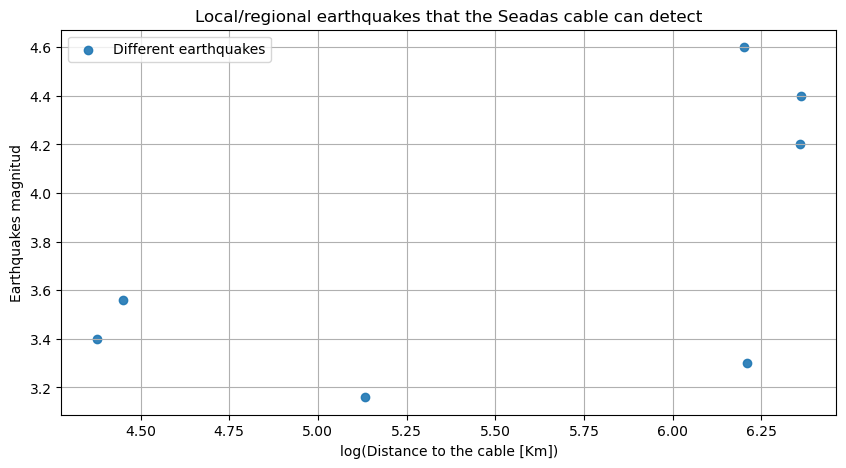

In [7]:
#creating plot distance vs magnitud (real earthquakes that we can see)
newmagtnitud=[magnituddarray[9],magnituddarray[12],magnituddarray[18],magnituddarray[21],magnituddarray[23],magnituddarray[25],magnituddarray[27]]
newdist_kmarray=[dist_kmarray[9],dist_kmarray[12],dist_kmarray[18],dist_kmarray[21],dist_kmarray[23],dist_kmarray[25],dist_kmarray[27]]
plt.subplots(figsize=(10,5))
plt.scatter(np.log(newdist_kmarray),newmagtnitud,s=None, marker='o', alpha=0.9, label='Different earthquakes')
plt.title('Local/regional earthquakes that the Seadas cable can detect')
plt.xlabel('log(Distance to the cable [Km])')
plt.ylabel('Earthquakes magnitud');
plt.legend()
plt.grid()
plt.savefig("seadaslocalquakes")
plt.show()
plt.close()

In [8]:
#testing pandas catalog
df=pd.read_csv('Catalog-SeaDas-lowmagnitud2.csv')  
df

,Magnitud,id_event,Location,detect_seismO,detect_das,clipped,channels,comments
0,2.88,uw61891152,113.590323,none,norecord,no,no,NaN
1,2.70,us6000ja7y,599.935770,none,norecord,no,no,NaN
2,2.90,us6000ja7t,601.710486,none,norecord,no,no,NaN
3,2.75,uw61898611,124.646945,none,norecord,no,no,NaN
4,2.91,uw61898541,121.801425,none,NaN,no,no,NaN
5,2.95,uw61876107,178.532100,none,TRUE,no,3190,NaN
6,2.90,us6000infa,596.555100,yes,TRUE,si,5742,NaN
7,2.90,us6000i8av,599.608916,none,norecord,no,no,NaN
8,2.70,us6000i80c,526.522234,none,norecord,no,no,NaN
9,2.84,uw61856377,NaN,none,no recortd,no,NaN,NaN


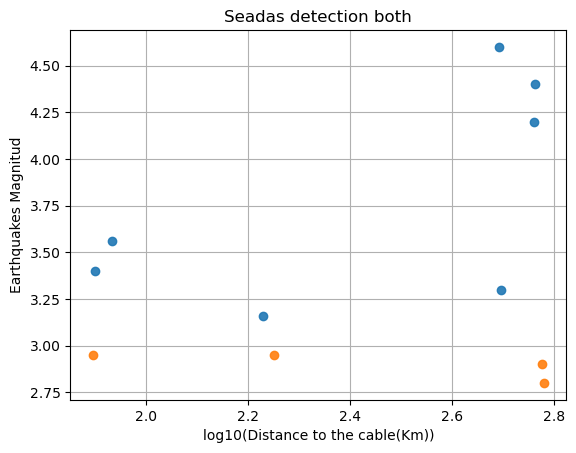

In [10]:
selected_rows = df[df.detect_das == 'TRUE']
plt.scatter(np.log10(newdist_kmarray),newmagtnitud,s=None, marker='o', alpha=0.9, label='Magnitud 3 to 5 Mw')
plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud,s=None, marker='o', alpha=0.9, label='Magnitud 2.7 to 2.99')
plt.xlabel('log10(Distance to the cable(Km))')
plt.ylabel('Earthquakes Magnitud')
plt.title('Seadas detection both')
plt.grid()
plt.savefig("SeaDaslocalquakes-lowbigmagnitud")
plt.show()

#plt.scatter(np.log10(selected_rows.Location),selected_rows.Magnitud)
#plt.scatter(selected_rows.Magnitud, selected_rows.Location)
